In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import datetime as dt
from datetime import datetime
import sklearn
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess

ROOT = "C:/Users/"

# ESTUDIO DE LOS DATOS DE LAS VENTAS

Este proyecto propone el estudio de las ventas de una empresa para la realización de un algoritmo que sea capaz de predecir dichas ventas. El proyecto propone un ciclo de estudio semanal, con posibilidad de estudiar alternativas. Serán propuestos una serie de algoritmos de diversa naturaleza y se estudiará su comportamiento para encontrar la alternativa más adecuada a dicha predicción, justificando dicha elección.

El código y estrategias empleados para este estudio previo, han sido extraidos e inspirados de los siguientes enlaces:

- https://towardsdatascience.com/finding-seasonal-trends-in-time-series-data-with-python-ce10c37aa861
- https://www.machinelearningplus.com/time-series/time-series-analysis-python/

Van a ser empleados modelos de TBATS, SARIMAX y RNN. Se proponen a futuro la prueba con otros métodos y algoritmos como Prophet y XGBoost aplicado a Time Series. Ejemplos de guías:

- https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html
- https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

### Importación y estudio de los datos en bruto

En primer lugar se han de recoger las tres bases de datos que contienen la información susceptible de explicar posteriormente el comportamiento de ventas.

In [2]:
df_clientes = pd.DataFrame()
df_dim_pedidos = pd.DataFrame()
df_pedidos = pd.DataFrame()
# los tres dataset
df_clientes = df_clientes.append(pd.read_csv(ROOT + ".csv", delimiter = ','))
df_dim_pedidos = df_dim_pedidos.append(pd.read_csv(ROOT + ".csv", delimiter = ','))
df_pedidos = df_pedidos.append(pd.read_csv(ROOT + ".csv", delimiter = ','))

Se comprueba si los clientes pueden aportar información útil para la predicción.

- Como se puede observar, cuando se retiran las filas con datos vacíos (NAN), los casos son casi anecdóticos, como se verá en las tablas posteriores. Si bien no se ha realizado el debido análisis de estos NAN y estos podrían ser datos fáciles de imputar, su inclusión en el dataset final no tendrá un impacto notable como para que merezca la pena la inversión de tiempo.

In [3]:
# Limpia NAN de clientes.
print(df_clientes.shape)
df_clientes = df_clientes.dropna()
print(df_clientes.shape)
df_clientes.head()

(177, 5)
(174, 5)


,digit_digit_sm_ciudad,digit_digit_sm_codigopais,digit_digit_sm_codigopostal,digit_digit_sm_idcliente,digit_digit_sm_idprovincia
0,HONDARRIBIA,1,20280,001-904,00101720
1,IRUN,1,20305,001-900,00101720
2,IRUN,1,20305,001-580,00101720
3,IRUN,1,20305,001-901,00101720
4,IRUN,1,20305,001-577,00101720


In [4]:
# Muestra todas las veces que aparecieron cada una de las ciudades, empezando por las más repetidas.
df_clientes['digit_digit_sm_ciudad'].value_counts()

IRUN                      28
OIARTZUN                   5
DONOSTIA-SAN SEBASTIAN     4
VITORIA-GASTEIZ            3
LEON                       3
                          ..
PUYÔO                      1
WEIL AM RHEIN              1
GALLARTA                   1
SONDIKA                    1
LOIU                       1
Name: digit_digit_sm_ciudad, Length: 112, dtype: int64

In [5]:
# Muestra todas las veces que aparecieron cada uno de los paises, empezando por los más repetidos.
df_clientes['digit_digit_sm_codigopais'].value_counts()

1      113
73      42
56       7
107      5
55       2
54       1
75       1
161      1
163      1
181      1
Name: digit_digit_sm_codigopais, dtype: int64

- De lo que se ha podido extraer de las líneas anteriores se deduce que las ventas están muy repartidas, siendo la ciudad más mencionada IRUN. Aun así, al estar tan repartido, sería difícil emplearlo como variable predictora.

- Respecto de los países en los que se realizó pedido, en este caso la participación del país "1" y "73" es más notable. Si bien los países por separado no son buenos predictores, se propone crear una variable decimal que indique en esa unidad de tiempo que porcentaje de pedidos se realizaron desde el país "1".

Para saber exáctamente de que país, el nombre de las ciudades que le corresponden delatan a dicho país. Así se ve que el país "1" era de hecho España y el siguiente mas numeroso es Francia.

In [6]:
numero_de_pais = 73

df_clientes['digit_digit_sm_ciudad'].loc[df_clientes['digit_digit_sm_codigopais'] == numero_de_pais].head()
# 1 (españa), 73 (francia), 56 (alemania)...

32               ST LOUBES
34      LA SUZE-SUR-SARTHE
40                MONÉTEAU
43    LA CHARITÉ SUR LOIRE
44       OCTEVILLE-SUR-MER
Name: digit_digit_sm_ciudad, dtype: object

- Respecto de la base de datos de los pedidos se obtendrán las fechas "digit_digit_sm_fechapedido" para poder realizar las operaciones finales. Esta base se conectará con la de los datos numéricos a través de la variable ID "digit_digit_sm_idpedido". Podría conectarse con la tabla anterior a través de la variable ID "digit_digit_sm_idcliente".

In [7]:
# limpia nan de pedidos
print(df_dim_pedidos.shape)
df_dim_pedidos = df_dim_pedidos.dropna()
print(df_dim_pedidos.shape)
df_dim_pedidos.head()

(15408, 6)
(15408, 6)


,digit_digit_sm_codpedido,digit_digit_sm_fechapedido,digit_digit_sm_fecharecepcion,digit_digit_sm_idcliente,digit_digit_sm_idpedido,digit_digit_sm_serie
0,P/9994,28/08/2014,10/10/2014,001-127,001-p/9994,001-2p
1,P/9995,28/08/2014,17/10/2014,001-127,001-p/9995,001-2p
2,P/9993,28/08/2014,03/10/2014,001-127,001-p/9993,001-2p
3,P/9998,29/08/2014,29/08/2014,001-127,001-p/9998,001-2p
4,P/21199,03/02/2022,04/03/2022,001-127,793d8d10-fc54-4b2f-9ee7-ce82fe0d48f8,001-2p


La diferencia entre la fecha en que se realizó el pedido y la del recibo podría ser susceptible de estudio el tiempo de tardanza en días, así como la razón por la que hay fechas negativas. Pues no tendría sentido que llegasen envíos antes de ser solicitados. Quizás pueda significar algo que la empresa no ha indicado, o un error.

In [8]:
#df_dim_pedidos['tiempo_llegada'] = datetime.strptime(df_dim_pedidos['digit_digit_sm_fecharecepcion'], '%d-%m-%Y') - datetime.strptime(df_dim_pedidos['digit_digit_sm_fechapedido'], '%d-%m-%Y')
df_dim_pedidos['tiempo_llegada'] = pd.to_datetime(df_dim_pedidos['digit_digit_sm_fecharecepcion']) - pd.to_datetime(df_dim_pedidos['digit_digit_sm_fechapedido'])
df_dim_pedidos['tiempo_llegada']

0         43 days
1         50 days
2       -171 days
3          0 days
4         32 days
           ...   
15403    227 days
15404   -136 days
15405    145 days
15406    -90 days
15407    221 days
Name: tiempo_llegada, Length: 15408, dtype: timedelta64[ns]

Como se aprecia en los datos, el tiempo de retardo en días entre pedido y llegada está bastante equilibrado, ya que entre otras cosas, la situación más repetida (0 días de retardo) ocurrió 1877 veces de los 15408 casos que existen. Esto significa que podría ser una variable susceptible a ser predicha.

In [9]:
df_dim_pedidos['tiempo_llegada'].value_counts()

0 days       1877
31 days       363
29 days       330
24 days       276
32 days       263
             ... 
-334 days       1
478 days        1
327 days        1
538 days        1
566 days        1
Name: tiempo_llegada, Length: 675, dtype: int64

- Respecto de la base de datos de los valores de cada pedido, la variable que se propone emplear a la hora de la predicción va a ser "digit_digit_sm_cantidad" que indica la *cantidad* de unidades que se vendió de cada producto en cada pedido. Bien podrían ser susceptibles de predicción el importe neto (que podría representar los beneficios de la empresa) o la discrepancia entre envíos y facturaciones.

In [10]:
# limpia nan de datos de pedidos
print(df_pedidos.shape)
df_pedidos = df_pedidos.dropna()
print(df_pedidos.shape)
df_pedidos.head()

(47414, 8)
(47409, 8)


,digit_digit_sm_cantidad,digit_digit_sm_concepto,digit_digit_sm_idlineapedido,digit_digit_sm_idpedido,digit_digit_sm_idproducto,digit_digit_sm_importeneto,digit_digit_sm_unidsenviadas,digit_digit_sm_unidsfacturadas
0,3,Silla BOB XL varilla Negro Texturado,001-p/9999-3,001-p/9999,001-1200bbpa0101nt,"51,7200000000",3,3
1,4,Silla BOB XL varilla Blanco Texturado,001-p/9999-4,001-p/9999,001-1200bbpa0101bt,"68,9600000000",4,4
2,12,Taburete KLIK alto Verde Pastel,abae8b9b-3e48-4954-93a1-f348615bf305,793d8d10-fc54-4b2f-9ee7-ce82fe0d48f8,001-1127katb0001vg,"0,0000000000",0,0
3,12,Taburete KLIK alto Topo RAL 7006,625064a7-d22d-47f8-ae75-86a33f991321,793d8d10-fc54-4b2f-9ee7-ce82fe0d48f8,001-1127katb0001to,"0,0000000000",0,0
4,3,Silla BOB XL varilla Bruto,001-p/9999-1,001-p/9999,001-1200bbpa0101br,"40,2900000000",3,3


La discrepancia entre unidades enviadas y facturadas representa muchas posibilidades a la hora de ser comprendida y es necesaria una mayor comunicación con el proveedor de la información. En la enorme mayoría de los casos, se enviaron tantos productos como se facturaron.

In [11]:
# Estudio de la discrepancia entre el envío y la facturación de cada uno de los productos por separado.
(df_pedidos['digit_digit_sm_unidsenviadas'] - df_pedidos['digit_digit_sm_unidsfacturadas']).value_counts()

 0       47356
 1          17
 10          4
 90          3
-1           3
 20          2
 6           2
 40          2
 80          2
 18          2
 5           2
 600         1
-2           1
 124         1
 2           1
 26          1
 3000        1
-60          1
 120         1
 22          1
 32          1
 16          1
 3           1
 265         1
 48          1
dtype: int64

# =============================================================

### Formacion del set de datos definitivo

- Para unificar ambas tablas de pedidos, se realiza una tabla auxiliar (df_aux) que exprese el número de productos vendidos en cada uno de los pedidos (cantidad) y conectarlos a traves de sus IDs.
- **Bién podría sustituirse la cantidad con el importe neto sustituyendo "digit_digit_sm_cantidad" por "digit_digit_sm_importeneto".**

In [12]:
# Selecciona el ID de un pedido y agrupa la cantidad de productos de ese pedido en una tabla auxiliar.
df_aux = pd.DataFrame()
df_aux['cantidad'] = df_pedidos.groupby('digit_digit_sm_idpedido')['digit_digit_sm_cantidad'].sum()
df_aux = df_aux.reset_index() # groupby convierte la variable clave en index, por lo que hay que desconvertir
print(df_aux.shape)
df_aux.head()

(15407, 2)


,digit_digit_sm_idpedido,cantidad
0,001-p/10000,2
1,001-p/10001,10
2,001-p/10002,17
3,001-p/10003,36
4,001-p/10004,480


- Se crea el dataset (df) sobre el que se va a trabajar y se le añaden las variables de las fechas (timestamp) sobre las que se ordenarán los datos y las IDs (id_pedido).

Las IDs servirán para rellenar el número de ventas (cantidad) con los datos de la tabla auxiliar mediante la función join.

In [13]:
df = pd.DataFrame() # Siendo df el dataset final.
df['timestamp'] = pd.to_datetime(df_dim_pedidos['digit_digit_sm_fechapedido']) # extrae fechas
df['id_pedido'] = df_dim_pedidos['digit_digit_sm_idpedido'] # extrae id para añadir la información del pedido
# Adición de la variable cantidad;
df = df.join(df_aux.set_index('digit_digit_sm_idpedido'), on = 'id_pedido') # añade información de pedido
df = df.drop(['id_pedido'], axis = 1) # elimina la columna auxiliar de los pedidos que ya no hace falta
df.head()

,timestamp,cantidad
0,2014-08-28,511.0
1,2014-08-28,384.0
2,2014-08-28,572.0
3,2014-08-29,10.0
4,2022-03-02,24.0


Hay que remarcar que es muy importante asegurarse de que los datos estén ordenados a la hora de predecir time series, ya que la progresión es esencial para crear una historia que pueda llegar a predecirse por un algoritmo. 

In [14]:
df = df.sort_values(by = 'timestamp', ascending = True) # ordena según el timestamp, es decir, en el tiempo

El modelo actual agrupa las muestras por pedido, mientras que el modelo que se desea predecir sería en un sentido semanal. Es por eso que se crearán dos variables auxiliares para la agrupación de dichos valores (cantidad), mediante la función groupby en modo sumatorio. Estas variables son la semana del año (week) y el año (year). Las semanas son respecto de lo que se agrupan los valores, pero se debe especificar el año tambien para que no se sumen los datos de la semana "1"  del año A con los de la semana "1" del año B.

In [15]:
df['week'] = df['timestamp'].dt.isocalendar().week # una columna con la semana del año
df['year'] = df['timestamp'].dt.year # una columna para años
df = df.set_index(['week', 'year']) # groupby necesita establecer semanas y años como índice para operar en funcion de ellos
df['cantidad'] = df.groupby(['week', 'year'])['cantidad'].sum() # agrupa los pedidos que se produjeron la misma semana del año
df = df[~ df.index.duplicated(keep = 'first')] # elimina las replicas que se han producido en la agrupacion anterior
df.head()

,,timestamp,cantidad
week,year,,
2,2010,2010-01-12,31.0
6,2010,2010-02-11,1228.0
10,2010,2010-03-11,435.0
14,2010,2010-04-11,160.0
25,2010,2010-06-21,367.0


Se restablece el tiempo como índice único del modelo y se eliminan los datos de ventas que fueran menores o iguales a 0 para poder ser estudiados por la función seasonal.

In [16]:
df = df.reset_index().set_index(['timestamp']) # cambia timestamp de index
df = df.drop(['week', 'year'], axis = 1) # elimina las columnas innecesarias
# elimina posibles nan
print(df.shape)
df = df.dropna()
print(df.shape)
# elimina negativos y ceros para poder aplicar seasonal
df = df[df['cantidad'] > 0]
df

(583, 1)
(583, 1)


,cantidad
timestamp,
2010-01-12,31.0
2010-02-11,1228.0
2010-03-11,435.0
2010-04-11,160.0
2010-06-21,367.0
...,...
2021-11-01,8117.0
2021-11-10,4097.0
2021-12-01,29122.0


Representación de los valores finales;

<AxesSubplot:xlabel='timestamp'>

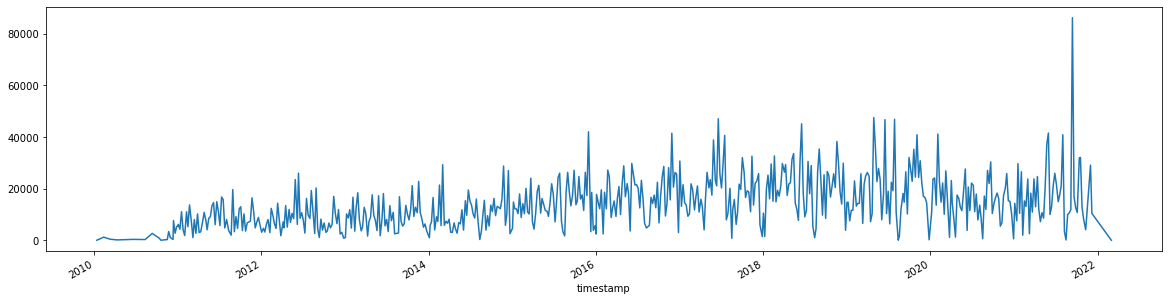

In [17]:
# tiempo completo de vida de la empresa
df.cantidad.plot(figsize = (20, 5), label = 'weekly')

Además, se van a proponer dos variables particularmente complejas para ser explicadas por un modelo y que van a alterar el comportamiento de las ventas muy drásticamente; la influencia de la crisis económica del 2008 (con mayor impacto en la demanda) y la influencia de la crisis del covid en las ventas (con mayor impacto en la oferta, debido al paro de la producción).

Estas variables han sido definidas como binarias para indicar un acontecimiento y para su desarrollo se han asumido una serie de cuestiones:
- Debido a la falta de conocimiento técnico a cerca de dichas crisis, se asumen sus márgenes de acción de manera visual por el programador en base a como se comporta la tendencia aparente en la gráfica.
- Este impacto de las crisis va a ser asumido binario para establecer una clasificación. Esto no significa necesariamente que estas variables no puedan ser regresiones con tendencias mejor estudiadas.

Estas decisiones han sido tomadas para poder tener en cuenta los problemas de periodicidad derivados de las crisis, sin embargo, carecen de un estudio avanzado de los efectos. Este estudio avanzado excedía la complejidad de este proyecto, **pero es una buena propuesta de estudio y mejora a futuro**.

In [18]:
# Los valores de 50000 en vez de 1 se han establecido en este código para poder ser mejor representados en el plot.
df['crisis_oferta'] = 0 # Se va a crear una columna de crisis de oferta para intentar reflejar el efecto del covid
df['crisis_oferta'].loc[(df.index > '2020-03-14') & (df.index < '2021-05-01')] = 50000
df['crisis_demanda'] = 0 # Se va a crear una columna de crisis de demanda para intentar reflejar la crisis del 2008
df['crisis_demanda'].loc[(df.index > '2012-01-01') & (df.index < '2015-01-01')] = 50000

D:\Python\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


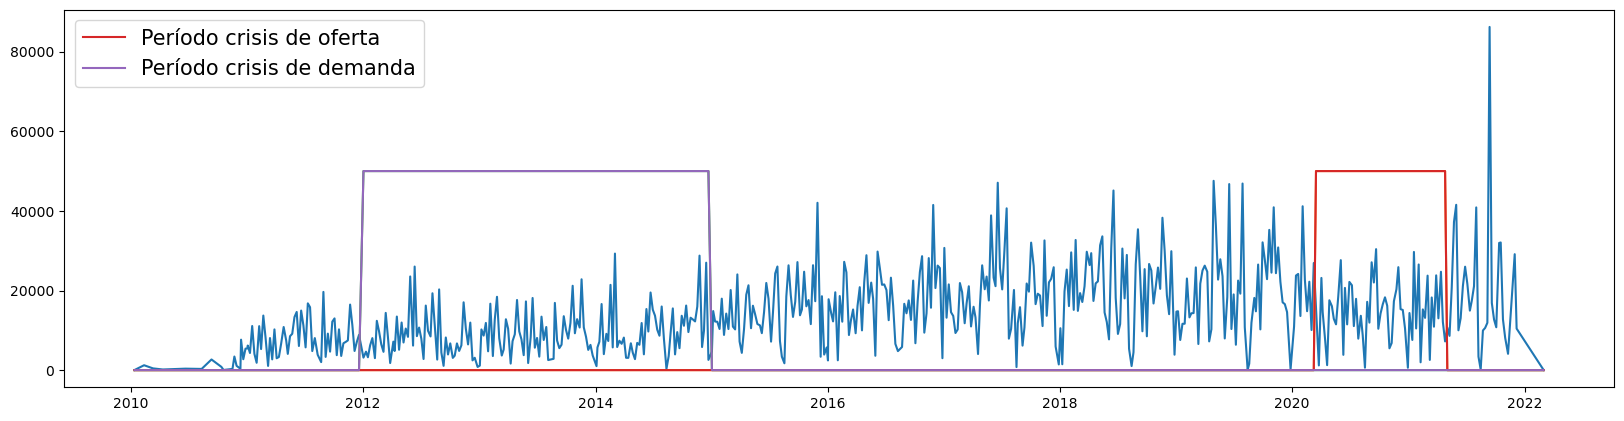

In [19]:
plt.figure(figsize = (20, 5), dpi = 100)
plt.plot(df)
plt.plot(df['crisis_oferta'], label = 'Período crisis de oferta')
plt.plot(df['crisis_demanda'], label = 'Período crisis de demanda')
plt.legend(loc = 'upper left', fontsize = 15)

Mediante esta representación, el área verde facilita la apreciación del crecimiento tendencial del modelo. Como se puede apreciar no hay un crecimiento muy evidente sobre el mismo modelo ni una periodicidad muy clara. Esto se verá más claro más adelante mediante algoritmos especializados en estudios de estacionalidad y tendencia.

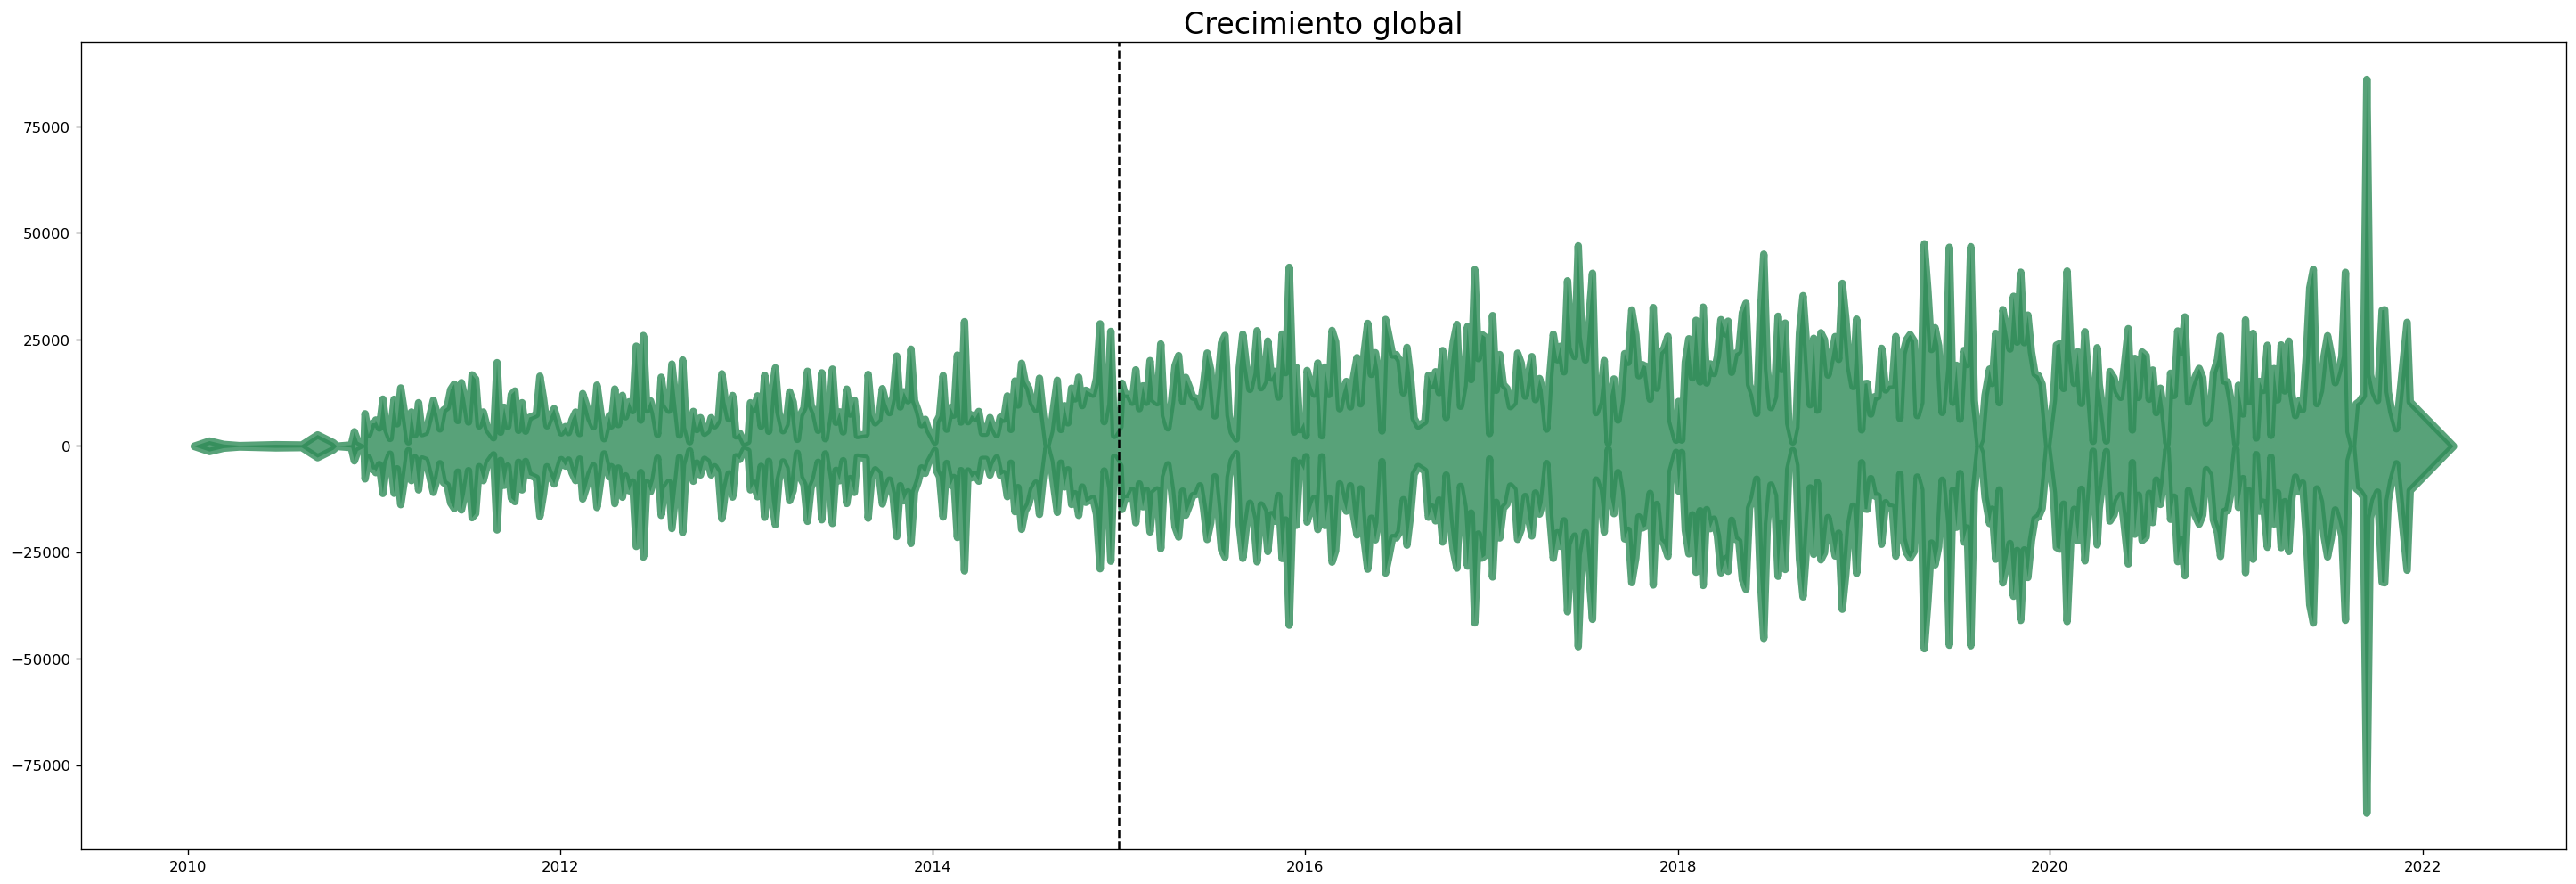

In [20]:
# Para enfatizar el crecimiento tendencial.
fig, ax = plt.subplots(1, 1, figsize = (30, 10), dpi = 120)
plt.fill_between(df.index, y1 = df['cantidad'], y2 = -df['cantidad'], alpha = 0.8, linewidth = 5, color = 'seagreen')
# plt.ylim(-1200, 1200)
plt.title('Crecimiento global', fontsize = 20)
plt.hlines(y = 0, xmin = np.min(df.index), xmax = np.max(df.index), linewidth = .5)
plt.axvline(x = pd.to_datetime('2015-01-01', format = '%Y-%m-%d'), color = 'black', linestyle = '--') # El corte del 2015
plt.show()
# Poco exclarecedor, pero se ve entre 2014-2016 un cambio tendencial que vuelve a contraerse tras 2020.

# =============================================================

### Muestra y selección de los datos importantes

Si se revisa la transición entre el año 2014 y 2016, se puede apreciar como a partir del 2015 hay un cambio de comportamiento y la variable cantidad se vuelve más intensa posteriormente, aunque esto no está demasiado claro. La elección de la fecha ha sido arbitraria para poder establecer un corte y comprender el comportamiento. Para mayor aclaración, sería importante preguntar al proveedor sobre el comportamiento del modelo.

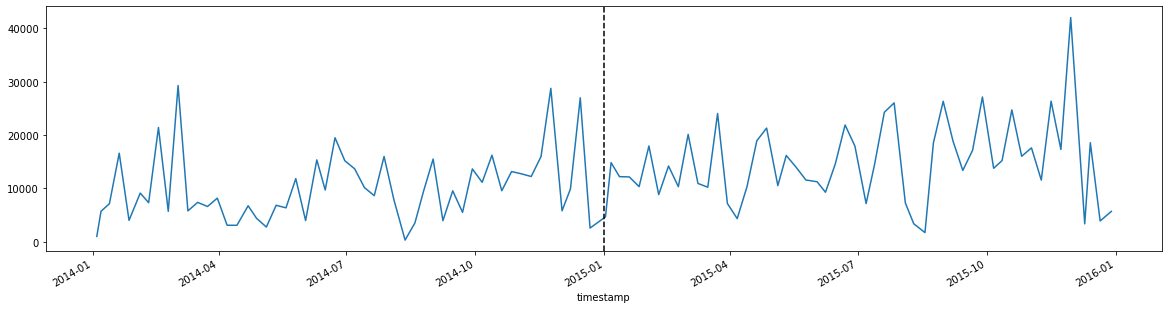

In [21]:
# Se delimitan las fechas de corte y se establecen como datetime para poder generar el nuevo dataset limitado (df_estudio).
from_ts = '2014-01-01'
to_ts = '2016-01-01'
df_estudio = df[(df.index < to_ts) & (df.index > from_ts)]
df_estudio.cantidad.plot(figsize = (20, 5), label = 'daily')
plt.axvline(x = '2015-01-01', color = 'black', linestyle = '--') # El corte del 2015

Si se estudia la dispersión mensual mediante diagramas de caja, se aprecia claramente un cambio en el comportamiento a partir del 2015, siendo este menos disperso y más ancho. Si bien el comportamiento es distinto, es creciente y menos drástico de lo que pudiera parecer a simple vista.

<ipython-input-22-abe3efbd99c7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_estudio['month'] = [d.strftime('%b') for d in df_estudio.index] # Se preparan el dataset para el plot de las cajas
<ipython-input-22-abe3efbd99c7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_estudio['month'] = [d.strftime('%b') for d in df_estudio.index]
<ipython-input-22-abe3efbd99c7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

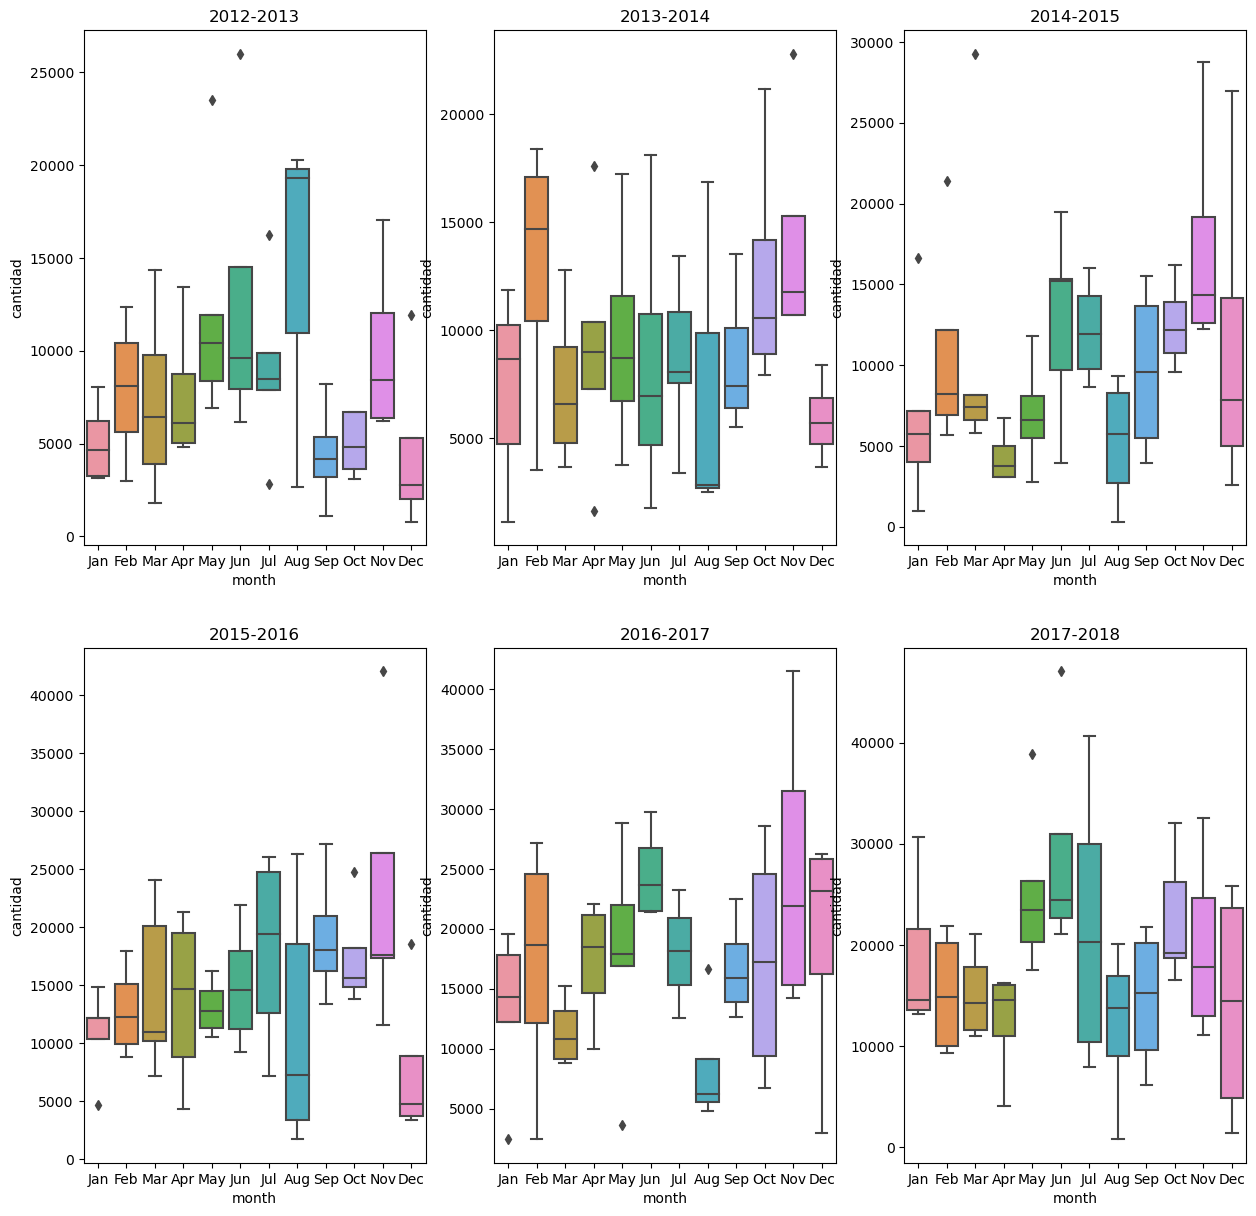

In [22]:
fig, ax = plt.subplots(2, 3, figsize = (15, 15), dpi = 100)
df_estudio = df[(df.index > '2012-01-01') & (df.index < '2013-01-01')]
df_estudio['month'] = [d.strftime('%b') for d in df_estudio.index] # Se preparan el dataset para el plot de las cajas
ax[0, 0].title.set_text('2012-2013')
sns.boxplot(ax = ax[0, 0], x = 'month', y = df_estudio.cantidad, data = df_estudio)

df_estudio = df[(df.index > '2013-01-01') & (df.index < '2014-01-01')]
df_estudio['month'] = [d.strftime('%b') for d in df_estudio.index]
ax[0, 1].title.set_text('2013-2014')
sns.boxplot(ax = ax[0, 1], x = 'month', y = df_estudio.cantidad, data = df_estudio)

df_estudio = df[(df.index > '2014-01-01') & (df.index < '2015-01-01')]
df_estudio['month'] = [d.strftime('%b') for d in df_estudio.index]
ax[0, 2].title.set_text('2014-2015')
sns.boxplot(ax = ax[0, 2], x = 'month', y = df_estudio.cantidad, data = df_estudio)

# Cajas de las ventas mensuales del año de transición a la nueva tendencia.
df_estudio = df[(df.index > '2015-01-01') & (df.index < '2016-01-01')]
df_estudio['month'] = [d.strftime('%b') for d in df_estudio.index]
ax[1, 0].title.set_text('2015-2016')
sns.boxplot(ax = ax[1, 0], x = 'month', y = df_estudio.cantidad, data = df_estudio)

df_estudio = df[(df.index > '2016-01-01') & (df.index < '2017-01-01')]
df_estudio['month'] = [d.strftime('%b') for d in df_estudio.index]
ax[1, 1].title.set_text('2016-2017')
sns.boxplot(ax = ax[1, 1], x = 'month', y = df_estudio.cantidad, data = df_estudio)

df_estudio = df[(df.index > '2017-01-01') & (df.index < '2018-01-01')]
df_estudio['month'] = [d.strftime('%b') for d in df_estudio.index]
ax[1, 2].title.set_text('2017-2018')
sns.boxplot(ax = ax[1, 2], x = 'month', y = df_estudio.cantidad, data = df_estudio)
plt.show()

Analizando el comportamiento tendencial actual a partir del 2015, se pueden separar los datos en años y comprobar la existencia de tendencias con consistencia en cada año.

In [23]:
# Se va a programar el comportamiento a partir de la nueva tendencia de ventas.
df = df[df.index > '2015-01-01']
#====================================================================================

# Margenes a estudiar por separado:
from_ts = ['2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01']
to_ts = ['2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01']
if len(from_ts) == len(to_ts):
    from_ts = pd.to_datetime(from_ts, format = '%Y-%m-%d')
    to_ts = pd.to_datetime(to_ts, format = '%Y-%m-%d')
else:
    print('FALLO: Discrepancia entre números de fechas de estudio.')

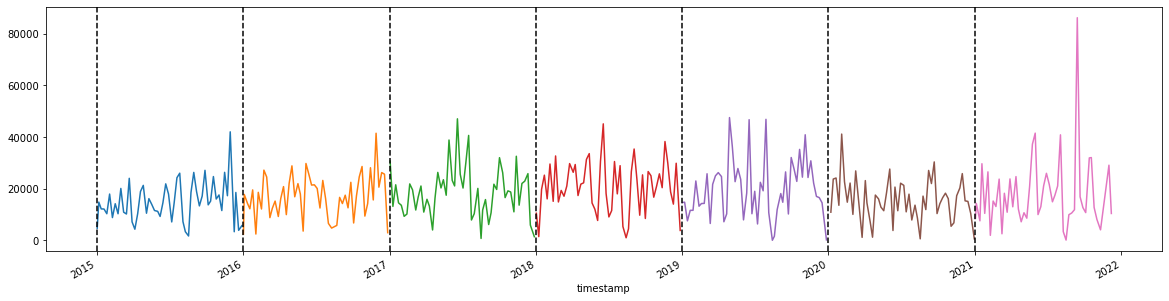

In [24]:
for x in range(len(from_ts)):
    df_estudio = df[(df.index < to_ts[x]) & (df.index > from_ts[x])]
    df_estudio.cantidad.plot(figsize = (20, 5))
    plt.axvline(x = from_ts[x], color = 'black', linestyle = '--')

Se seleccionan todos los años menos uno. Este uno sería para evitar incluir el año 2021 que distorsiona el resultado con el valor disparado de las ventas postcovid.

Una vez superpuestos los valores, no se puede ver una tendencia evidente más allá de una concentracion de picos en verano y un valle posterior, de naturaleza desconocida.

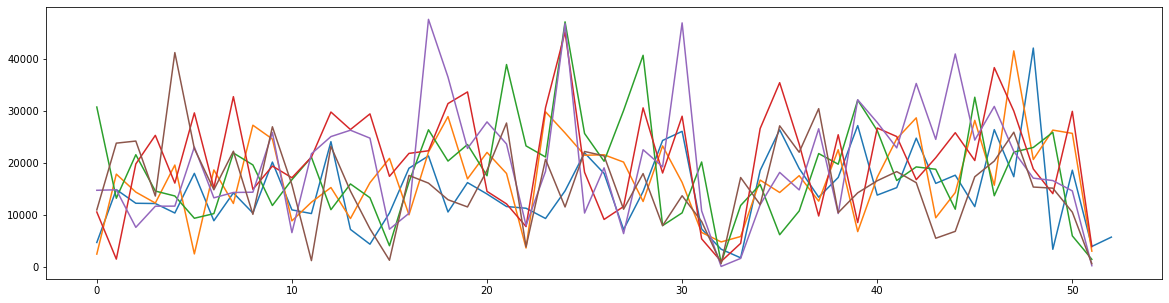

In [25]:
for x in range(len(from_ts) - 1):
    df_estudio = df[(df.index < to_ts[x]) & (df.index > from_ts[x])]
    df_estudio = df_estudio.reset_index(drop = True)
    df_estudio.cantidad.plot(figsize = (20, 5))

# =============================================================

### Estudio de estacionalidad

Va a ser empleada la funcion "seasonal_decompose" de la librería "statmodels". El objetivo de dicha función será buscar patrones, tendencias y poder separarlos del ruido para poder extraer información susceptible de ser empleada para la predicción.
- Hay que aclarar que se tiene que establecer un período, y este no puede ser mayor que el tamaño de la muestra.

Enlace con otros ejemplos de aplicación del código:
- https://towardsdatascience.com/finding-seasonal-trends-in-time-series-data-with-python-ce10c37aa861

Lo que se aprecia de las siguientes tres imagenes, en la primera al principio la tendencia es ascendente constante hasta que llega a un máximo de crecimiento, con lo que la empresa no tiene espectativas de crecimiento de manera constante y regular. Todo esto obviando la drastica caida del crecimiento provocada por el covid.

Además, el patrón de la estacionalidad es demasiado pequeño para poder percibir si es real o es el mismo programa que intenta forzar dicho patrón.

Text(0, 0.5, 'Residuos')

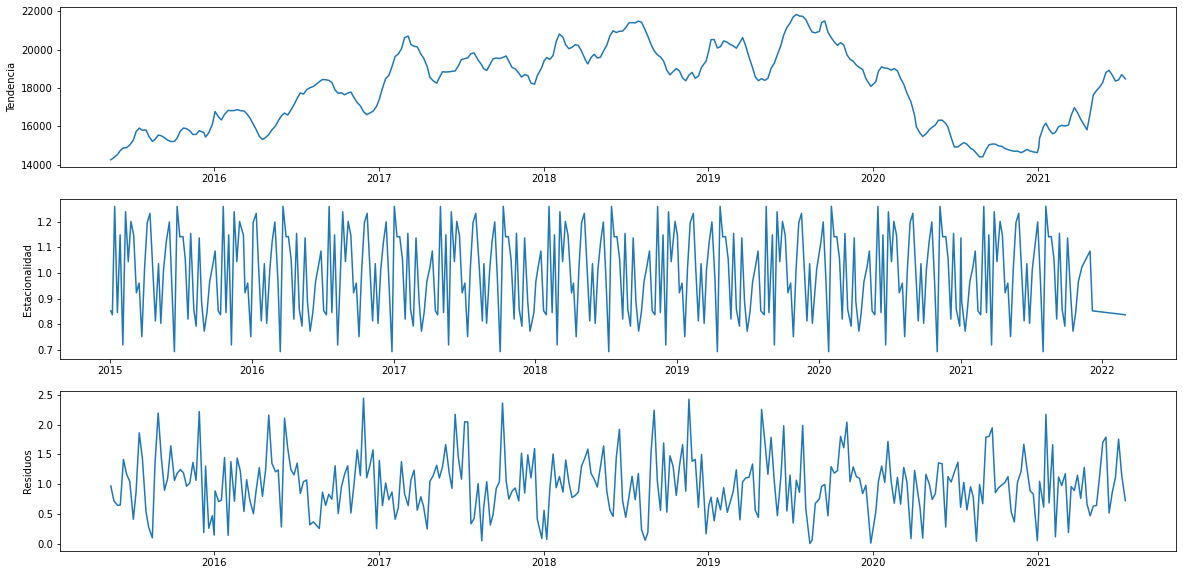

In [26]:
# Separacion entre la tendencia, la estacionalidad y los residuos del histórico completo.
decompose_result_mult = seasonal_decompose(df['cantidad'], model = "multiplicative", period = 40)
# seasonal_decompose devuelve un objeto con los tres atributos que definen el comportamiento
# los tres subplots
fig, ax = plt.subplots(3, figsize = (20, 10))
ax[0].plot(decompose_result_mult.trend)
ax[0].set_ylabel('Tendencia')
ax[1].plot(decompose_result_mult.seasonal)
ax[1].set_ylabel('Estacionalidad')
ax[2].plot(decompose_result_mult.resid)
ax[2].set_ylabel('Residuos')

Si se analizase por separado cada año, se aprecia ahora claramente como cada año seasonal_decompose fuerza una estacionalidad completamente distinta, por lo que **no se aprecia una estacionalidad regular**.

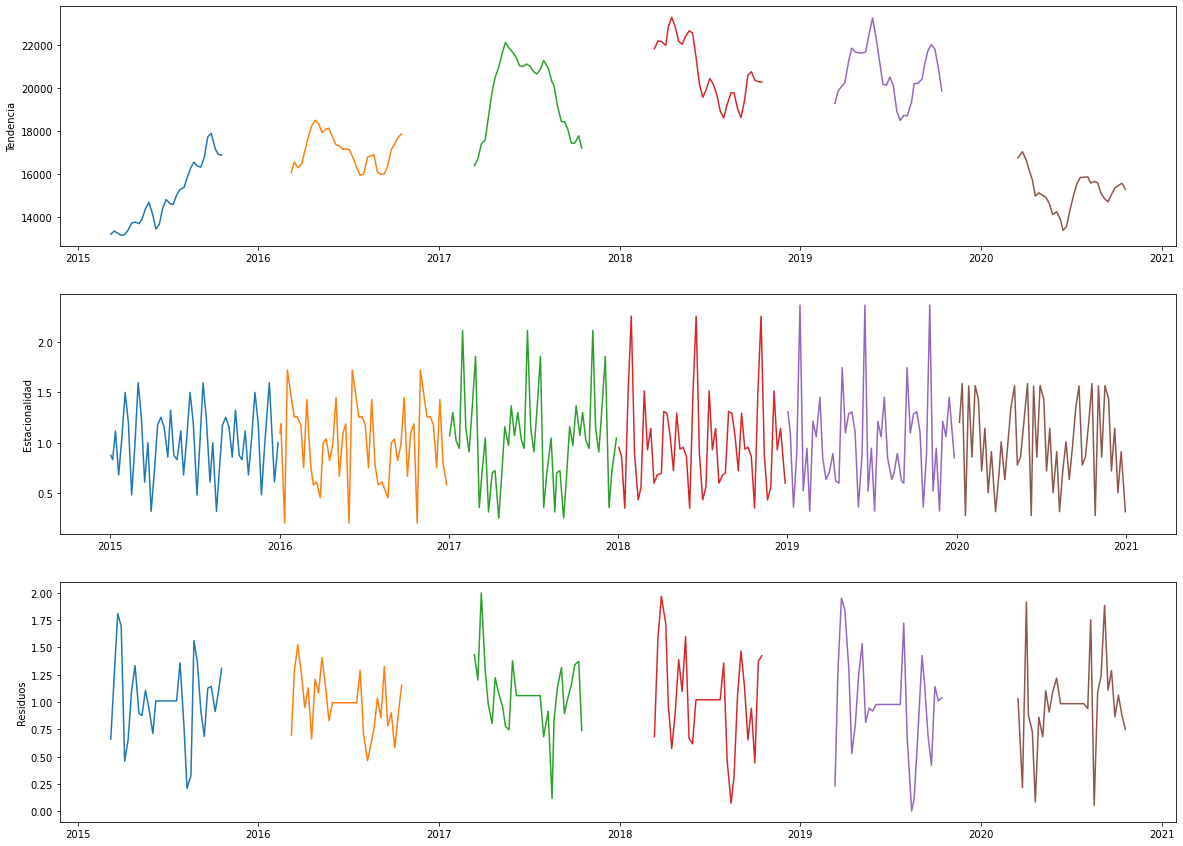

In [27]:
fig, ax = plt.subplots(3, figsize = (20, 15))
for x in range(len(from_ts) - 1): # menos uno para quitar la ultima fecha que distorsiona el resultado con el valor disparado
    # limites del año
    df_estudio = df[(df.index < to_ts[x]) & (df.index > from_ts[x])]
    # descomposicion de la tendencia
    decompose_result_mult = seasonal_decompose(df_estudio['cantidad'], model = "multiplicative", period = 20)
    # los tres subplots
    ax[0].plot(decompose_result_mult.trend)
    ax[0].set_ylabel('Tendencia')
    ax[1].plot(decompose_result_mult.seasonal)
    ax[1].set_ylabel('Estacionalidad')
    ax[2].plot(decompose_result_mult.resid)
    ax[2].set_ylabel('Residuos')

### Estudio de las componentes de un solo año

Estos fragmentos de código sirven para poder estudiar un año por separado. No va a ser necesario pero no se elimina para que esta parte del código no se pierda. Seasonal_decompose separa los patrones, el ruido y la tendencia como si se estuvieran multiplicando para dar como resultado los valores en bruto. Esta separación también puede realizarse como si se estuvieran sumando, pero la diferencia entre ambos métodos es mínima. Generalmente se emplea lo primero, las componentes multiplicativas.

extrapolate_trend = 'freq' arregla el problema de que existan NAN (igualmente han sido retirados previamente)

Y las componentes aditivas:

### Estudio alternativo de estacionalidad - Test de autocorrelación

Al realizar la regresion lineal, si la señal es no estacionaria es porque hay correlaciones consigo misma y esto tiene que ser tenido en cuenta para una predicción. Lo ideal sería que la función fuese estacionaria, si no, tendría que separarse la componente tendencial de la estacional.

En este caso se proponen dos métodos cuantitativos (Unit Root Tests) diferentes para este estudio de la estacionalidad y autocorrelación:
- Augmented Dickey Fuller test (ADH Test)
- Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)

Con la mención del Philips Perron test (PP Test), aunque los más usados son los dos primeros. En ambos test, una de las hipotesis indicará la estacionalidad del modelo:

In [28]:
# ADF Test para el modelo completo con estacionalidades y con no estacionalidades
# En este caso la hipotesis nula es que es no estacionario
result = adfuller(df['cantidad'], autolag = 'AIC')
if result[1] > 0.05: # Si el P-value es no significativo
    print('Según ADF, el segmento es no estacionario')
else:
    print('Según ADF, el segmento es estacionario')

# KPSS Test
# En este caso la hipotesis nula es que es estacionario (lo contrario que ADF).
result = kpss(df['cantidad'], regression = 'c')
if result[1] > 0.05: # Si el P-value es no significativo
    print('Según KPSS, el segmento es estacionario')
else:
    print('Según KPSS, el segmento es no estacionario')

Según ADF, el segmento es estacionario
Según KPSS, el segmento es estacionario


D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


- Un test de autocorrelación es un estudio comparativo de una serie con sus propios retardos o lags. Esto implica que los resultados sucesivos del modelo son capaces de explicar en parte la tendencia del mismo modelo para ayudar en la predicción.
- En el caso de la autocorrelación parcial, se destila una autocorrelación más pura, omitiendo la influencia de lags intermedios del proceso. Estas autocorrelaciones parciales son un coeficiente del mismo lag en la misma ecuación regresiva de Y, que matemáticamente se expresan en forma de constantes en la ecuación de la regresión:
$$ {Y}_{t} = {\alpha}_{0} + {\alpha}_{1} {Y}_{t - 1} + {\alpha}_{2} {Y}_{t - 2} + {\alpha}_{3} {Y}_{t - 3} + ... + {\alpha}_{n} {Y}_{t - n} $$

El test puede tener en cuenta el número de lags que se desee (lags = x), pero solo se puede tener en cuenta un número existente de lags. Los resultados expresados en la gráfica parcial muestran que hay baja autocorrelación por el hecho de que los dos primeros coeficientes sobresalgan encima de la tendencia (cuantos más valores sobre salgan, mayor autocorrelación).

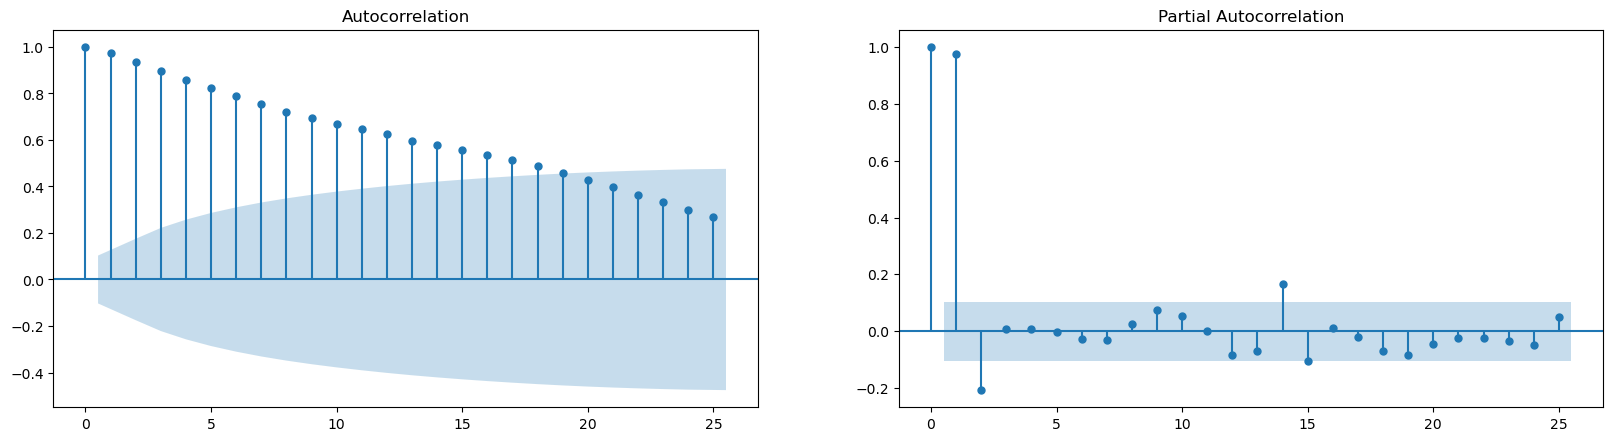

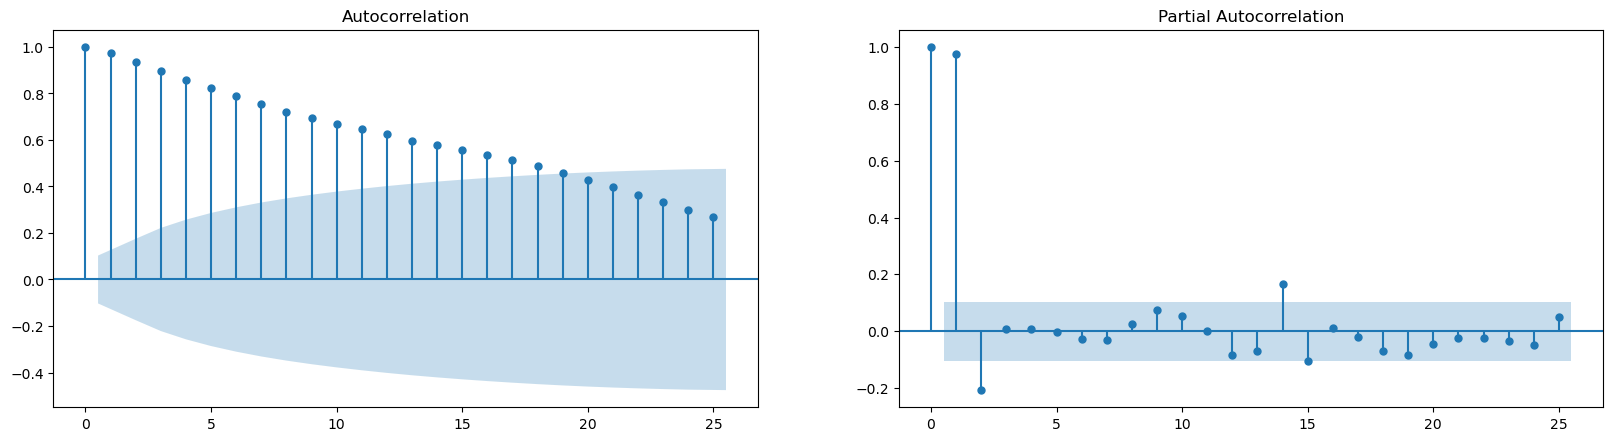

In [53]:
decompose_result_mult = seasonal_decompose(df['cantidad'], model = "multiplicative", period = 26, extrapolate_trend = 'freq')
fig, ax = plt.subplots(1, 2, figsize = (20, 5), dpi = 100)
# Autocorrelaciones y autocorrelaciones parciales.
plot_acf(decompose_result_mult.trend, lags = 25, ax = ax[0])
plot_pacf(decompose_result_mult.trend, lags = 25, ax = ax[1])

### Estudio alternativo de autocorrelación

Un diagrama de retardo o Lag Plot es un simple scatter plot en el que cada punto tiene como ejes los valores del lag principal y el otro lag con el que se desea comparar. Si el valor de los dos lags se parece mucho, el punto tenderá a situarse cerca de la diagonal. Si se aprecia un patrón más lineal en la nube, es decir, una forma alargada, es que hay cierta autocorrelación. Si el patrón es más disperso como en este caso, esto podría revelar una muy baja autocorrelación.

A medida que el número de lags aumenta este patrón es más disperso. Esto podría significar que los datos más anteriores pierden muy rápidamente su influencia en el resultado final.

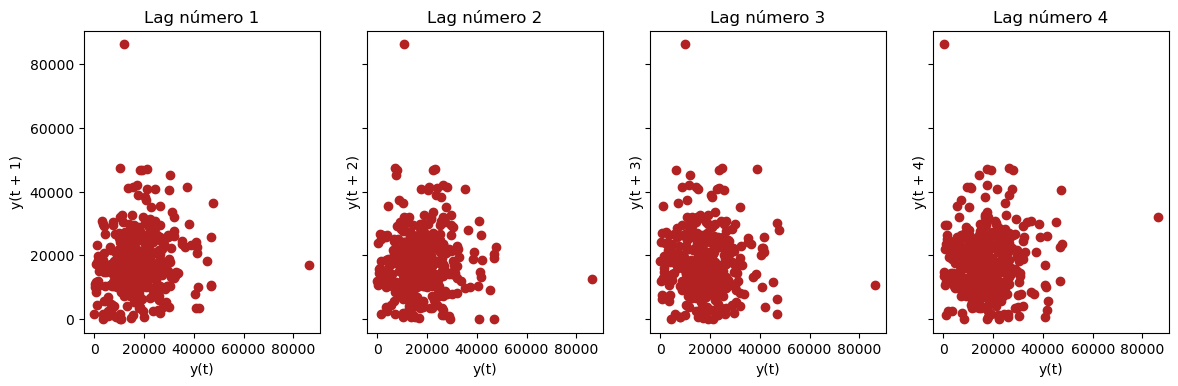

In [44]:
# Diagrama de retardo (lag plot) es un diagrama de una serie de tiempo respecto de sí misma.
fig, axes = plt.subplots(1, 4, figsize = (14, 4), sharex = True, sharey = True, dpi = 100)
for i, ax in enumerate(axes.flatten()[:4]): # Va a realizar la comparación con los 4 lags inmediatamente anteriores.
    lag_plot(df['cantidad'], lag = i + 1, ax = ax, c = 'firebrick') # Siendo el retardo (lag) el mismo valor más 1.
    ax.set_title('Lag número ' + str(i + 1))
  
plt.show()
# No se aprecia un patrón claro, por lo que parece haber solo cierta ligera autocorrelación en la salida.

# =============================================================

### Para poder explicar mejor un timeseries se puede suavizar la señal eliminando el ruido

Dada la falta clara de una tendencia mostrada por la función seasonal, lo cual complicaría la extracción del ruido, se propone una alternativa para facilitar la predicción. Generalizaciones del modelo a través del suavizado y regularizado de la tendencia completa. Para esto hay varios métodos, siendo el primero la eliminación de los residuos directamente.

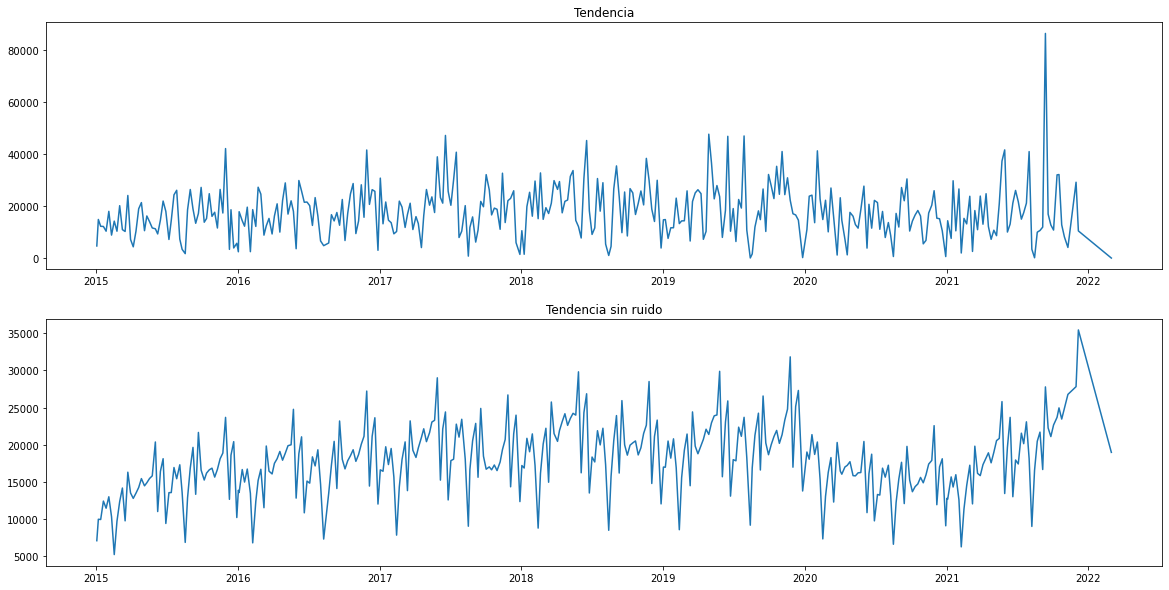

In [31]:
# Eliminando el ruido directamente.
decompose_result_mult = seasonal_decompose(df['cantidad'], model = "multiplicative", period = 26, extrapolate_trend = 'freq')
fig, ax = plt.subplots(2, figsize = (20, 10))
ax[0].title.set_text('Tendencia')
ax[0].plot(df['cantidad'])
ax[1].title.set_text('Tendencia sin ruido')
ax[1].plot(df['cantidad'] / decompose_result_mult.resid)

Mientras que el caso anterior no es bueno para realizar generalizaciones, el siguiente ejemplo, el LOESS smoothing (Localized Regression) y el LOWESS smoothing (Locally Weighted Regression) se realizan regresiones por vecindad. El hiperparámetro frac = x serviría para establecer la ventana de datos para la regresión. En este caso el suavizado es demasiado intenso.

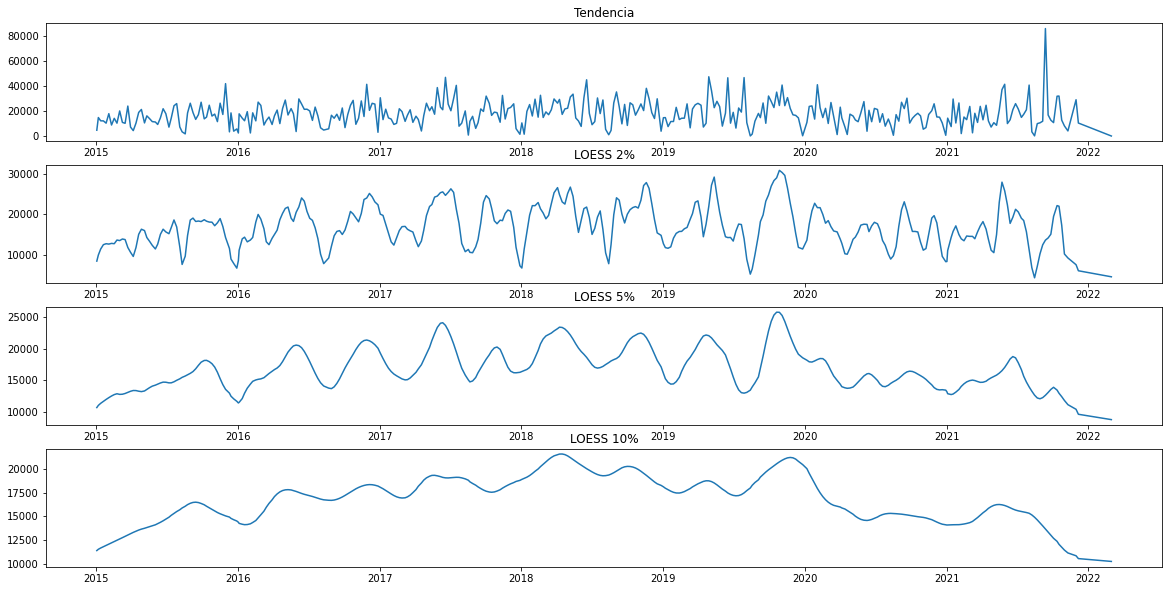

In [32]:
# Lowess Smoothing (2%, 5% y 10%).
df_lowess_2 = pd.DataFrame(lowess(df['cantidad'], np.arange(len(df['cantidad'])), frac = 0.02)[:, 1], index = df['cantidad'].index, columns = ['value'])
df_lowess_5 = pd.DataFrame(lowess(df['cantidad'], np.arange(len(df['cantidad'])), frac = 0.05)[:, 1], index = df['cantidad'].index, columns = ['value'])
df_lowess_15 = pd.DataFrame(lowess(df['cantidad'], np.arange(len(df['cantidad'])), frac = 0.1)[:, 1], index = df['cantidad'].index, columns = ['value'])
# La ventana de suavizado no debe ser muy grande, ya que podría sobresuavizarlo y modificarlo.
fig, ax = plt.subplots(4, figsize = (20, 10))
ax[0].title.set_text('Tendencia')
ax[0].plot(df['cantidad'])
ax[1].title.set_text('LOESS 2%')
ax[1].plot(df_lowess_2)
ax[2].title.set_text('LOESS 5%')
ax[2].plot(df_lowess_5)
ax[3].title.set_text('LOESS 10%')
ax[3].plot(df_lowess_15)

La opción que mejores resultados ha proporcionado en este caso ha sido la media de vecindad o Moving Average, que en este caso puede ser mejor afinada ya que se expresa el tamaño de la ventana unidad por unidad. En este caso es capaz de realizar una generalización mejor que simplemente extrayendo el ruido, pero además se puede ajustar para no distorsionar la forma.

En este caso se ha llegado a la conclusión que un marco de 2 datos de distancia sería la mejor opción.

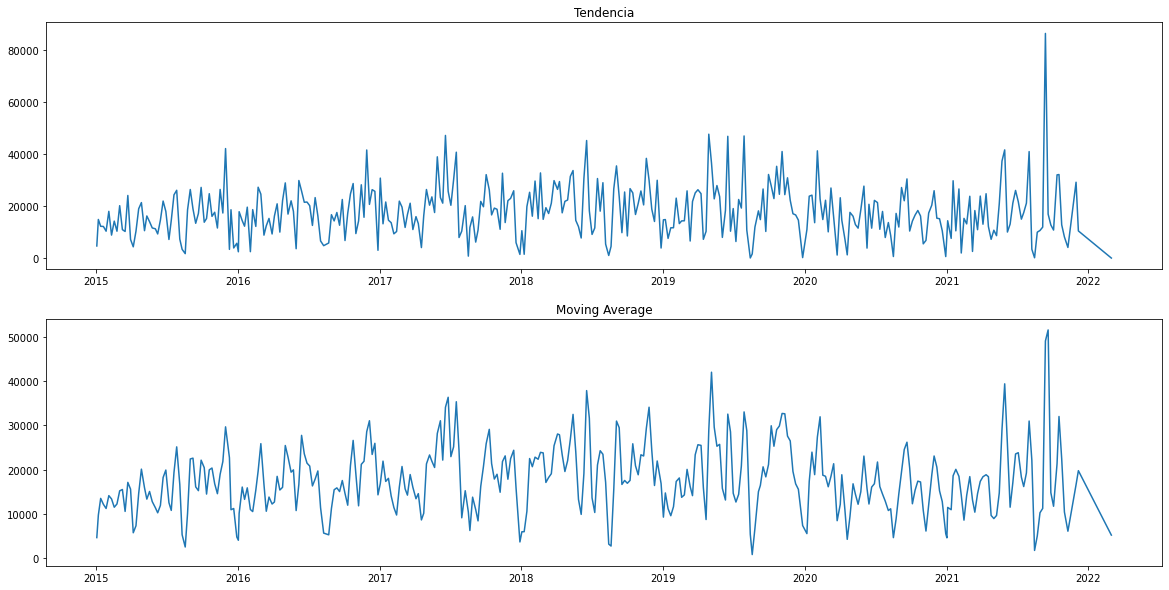

In [33]:
# Moving Average.
df_ma = df['cantidad'].rolling(1, center = True, closed = 'both').mean()
fig, ax = plt.subplots(2, figsize = (20, 10))
ax[0].title.set_text('Tendencia')
ax[0].plot(df['cantidad'])
ax[1].title.set_text('Moving Average')
ax[1].plot(df_ma)

**El modelo ha sido estudiado sin suavizado, pero el suavizado será empleado en códigos posteriores para hacer modelos más genericos de predicción.**

# =============================================================

### Código útil para casos de falta de datos

Una muestra de cinco métodos distintos para poder completar datos en falta. Más información en el primer enlace adjuntado al principio. Este es un código que no ha sido necesario, pero es interesante para ser comentado.